# Downscaling Windspeed for **Manhattan**

**Variables:**
* Variable to be downscaled: Wind Speed (WS)
* Predictor variable: Surface Pressure (PSFC) 

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 2,205.41 km²

# Import libraries

In [58]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

In [2]:
!python --version

Python 3.8.18


# Define paths and retrieve files from server

In [3]:
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/wind-NYC-split/train/uWRF_final_01-02.nc')
uwrf_val = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/wind-NYC-split/val/uWRF_final_03.nc')
uwrf_test = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/wind-NYC-split/test/uWRF_final_03.nc')

nam_train = xr.open_dataset('/home/gvaillant1/downscaling/data/WS-NYC-data/aligned_nam_train_data.nc')
nam_val = xr.open_dataset('/home/gvaillant1/downscaling/data/WS-NYC-data/aligned_nam_val_data.nc')
nam_test = xr.open_dataset('/home/gvaillant1/downscaling/data/WS-NYC-data/aligned_nam_test_data.nc')

# Define variables

In [5]:
#High resolution (uWRF) data
WS_hr_train = uwrf_train.WS
WS_hr_val = uwrf_val.WS
WS_hr_test = uwrf_test.WS

PSFC_hr_train = uwrf_train.PSFC
PSFC_hr_val = uwrf_val.PSFC
PSFC_hr_test = uwrf_test.PSFC

#--------------------------
#Low resolution (NAM) data
WS_lr_train = nam_train.WS
WS_lr_val = nam_val.WS
WS_lr_test = nam_test.WS

PSFC_lr_train = nam_train.PSFC
PSFC_lr_val = nam_val.PSFC
PSFC_lr_test = nam_test.PSFC

# Scale the data

In [6]:
WS_scaler_train = dds.StandardScaler(axis=None)
WS_scaler_train.fit(WS_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = WS_scaler_train.transform(WS_hr_train)
y_val = WS_scaler_train.transform(WS_hr_val)
y_test = WS_scaler_train.transform(WS_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = WS_scaler_train.transform(WS_lr_train)
x_val = WS_scaler_train.transform(WS_lr_val)
x_test = WS_scaler_train.transform(WS_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)

# Compare original resolutions

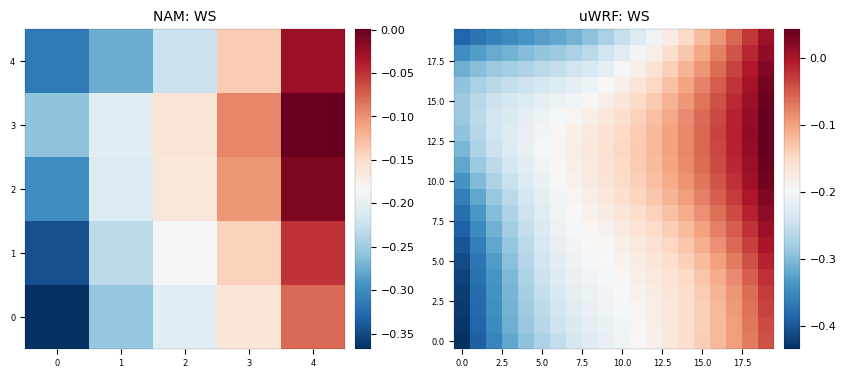

In [34]:
#WS: Wind Speed
ecv.plot((x_train[0].values, y_train[0]), subplot_titles=('NAM: WS', 'uWRF: WS'))

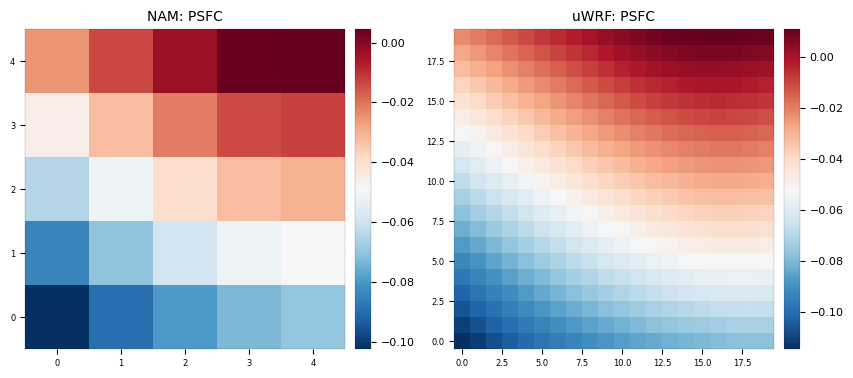

In [35]:
#PSFC: Surface Pressure
ecv.plot((x_z_train[0].values, y_z_train[0]), subplot_titles=('NAM: PSFC', 'uWRF: PSFC'))

# Add channel dimension

In [9]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

# Verify shape

In [10]:
print("Wind Speed hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PSFC hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("Wind Speed lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PSFC lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

Wind Speed hr data shape:
(1537, 20, 20, 1) (899, 20, 20, 1) (899, 20, 20, 1)

PSFC hr data shape:
(1537, 20, 20, 1) (899, 20, 20, 1) (899, 20, 20, 1)

Wind Speed lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)

PSFC lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)


# Example coarsening method occuring during training:

For this model, we do not use the LR data (NAM) during training. Instead, we use a coarsened version (via interpolation) of the HR (uWRF) WS and PSFC data. The DL4DS model carries out this interpolation on the fly by using the helper function dds.create_pair_hr_lr() (not to be called by the user). This process is done **automatically** inside the training loop (by calling one of the two (Supervised vs GAN) Trainer classes in DL4DS), which we examplify here with the spc upsampling. 

HR array: (20, 20, 1), LR array (5, 5, 2)


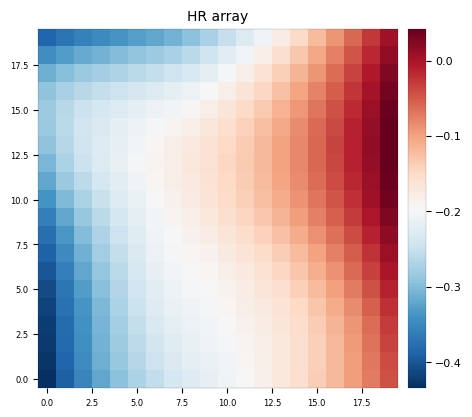

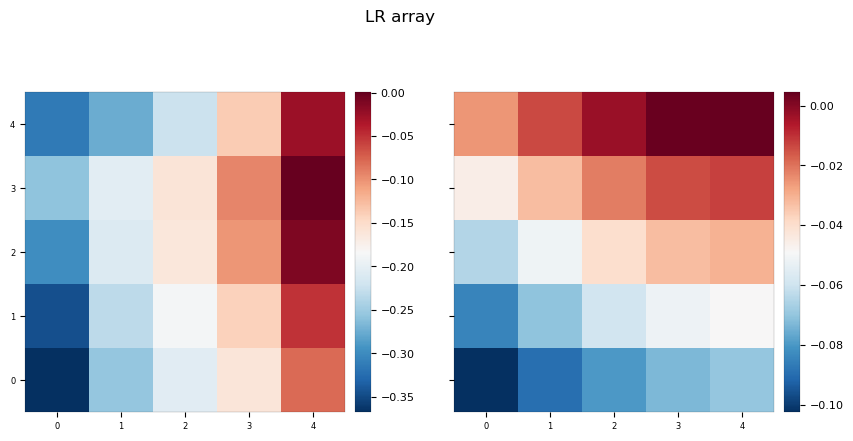

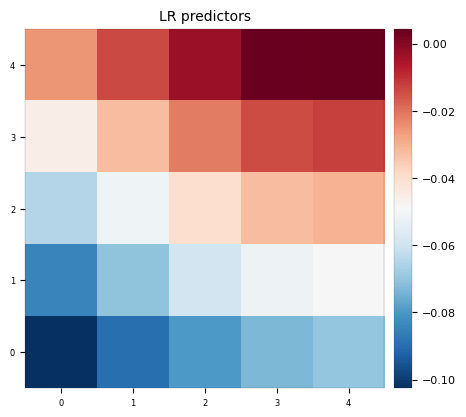

In [36]:
_ = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

# Training Model

Possible backbones:

* resnet
* densenet
* convnet
* convnext

In [12]:
ARCH_PARAMS = dict(n_filters=20,
                   n_blocks=4,
                   normalization=None,
                   dropout_rate=0.5,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=False)

trainer = dds.SupervisedTrainer(
    backbone='densenet',
    upsampling='spc', 
    data_train=y_train,
    data_val=y_val,
    data_test=y_test,
    data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    scale=4, 
    time_window=None, 
    static_vars=None,
    predictors_train=[y_z_train],
    predictors_val=[y_z_val],
    predictors_test=[y_z_test],
    interpolation='inter_area',
    patch_size=None, 
    batch_size=60,
    loss='mae',
    epochs=50, 
    steps_per_epoch=None, 
    validation_steps=None, 
    test_steps=None, 
    learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
    early_stopping=False, patience=6, min_delta=0, 
    save=False, 
    save_path=None,
    show_plot=True, verbose=True, 
    device='CPU',
    **ARCH_PARAMS)
trainer.run()

List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
--------------------------------------------------------------------------------
Starting time: 2025-01-16 09:29:23
--------------------------------------------------------------------------------
Model: "densenet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_1 (InputLayer)                        [(None, None, None, 2)]                      0              []                                           
                                                                                                                                                      
 conv2d (Conv2D)                             (None

# Inference on uWRF test set

In [13]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=[y_z_test], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=60,
    scaler=WS_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-16 09:30:41
--------------------------------------------------------------------------------
15/15 [==============================] - 1s 14ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:00.819827
--------------------------------------------------------------------------------


# Inference on NAM

In [49]:
pred1 = dds.Predictor(
    trainer, 
    x_train, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=[x_z_train], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=WS_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-16 13:26:42
--------------------------------------------------------------------------------
385/385 [==============================] - 2s 5ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:02.006178
--------------------------------------------------------------------------------


# Comparing predictions on uWRF test set

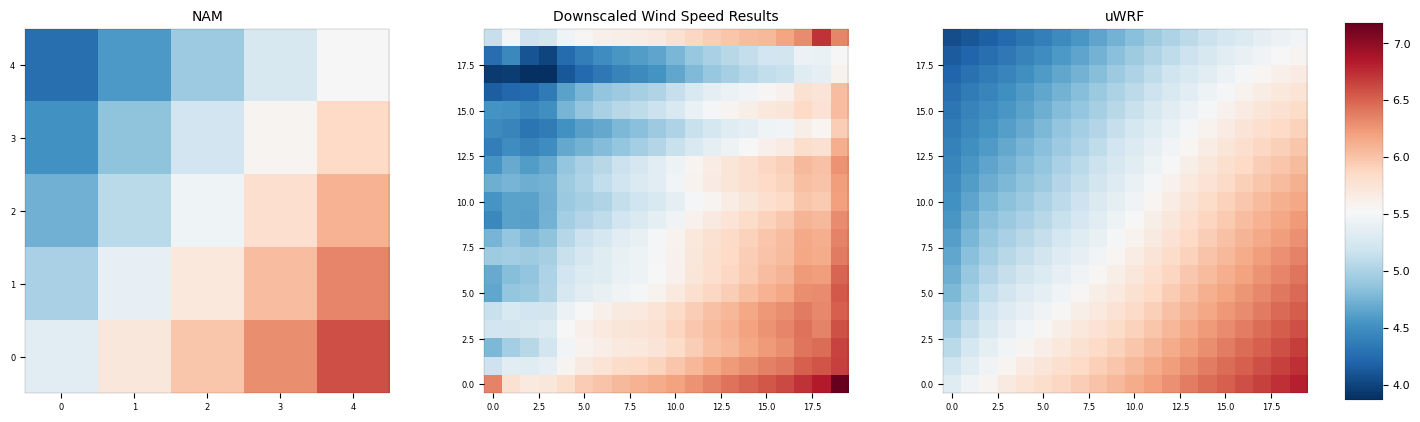

MAE for test set: 0.15352869033813477


In [46]:
unscaled_x_test = WS_scaler_train.inverse_transform(x_test)
unscaled_y_test = WS_scaler_train.inverse_transform(y_test)
ecv.plot((unscaled_x_test[0].values, unscaled_y_pred[0], unscaled_y_test[0].values),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Wind Speed Results', 'uWRF'))

mae = dds.losses.mae(unscaled_y_test[0].values, unscaled_y_pred[0])
print(f"MAE for test set: {mae}")

# Comparing predictions on NAM data

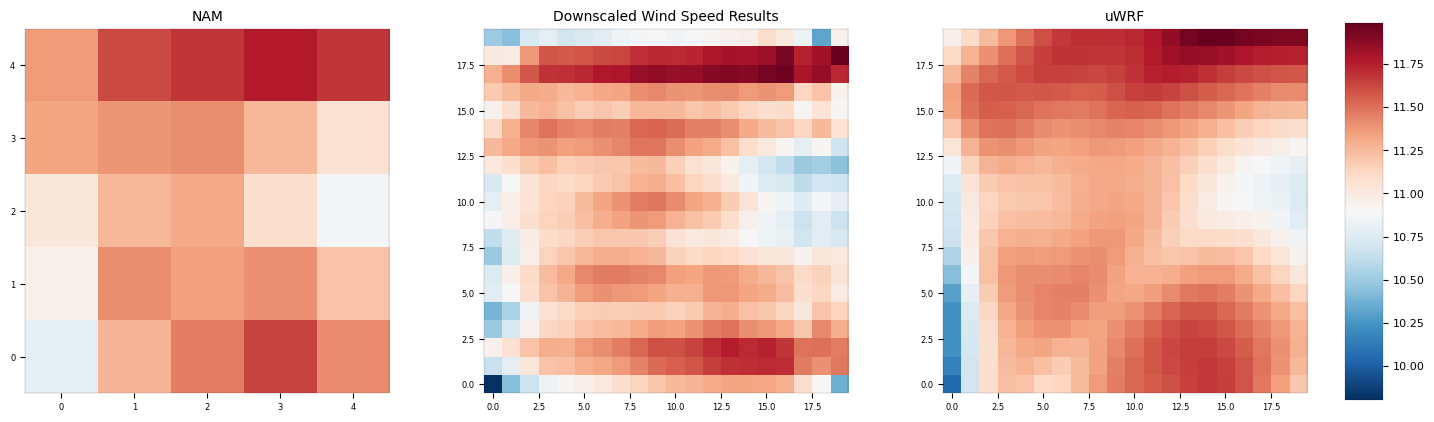

In [55]:
unscaled_y_train = WS_scaler_train.inverse_transform(y_train)
unscaled_x_train = WS_scaler_train.inverse_transform(x_train)
ecv.plot((unscaled_x_train[2].values, unscaled_x_pred[2], unscaled_y_train[2].values),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Wind Speed Results', 'uWRF'))

# Loss calculations

In [56]:
mae = dds.losses.mae(unscaled_y_test.values[1], unscaled_y_pred[1])
print(f"MAE for training: {mae}")

mse = dds.losses.mse(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MSE for training: {mse}")
print("")
mae_pred = dds.losses.mae(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MAE on NAM: {mae_pred}")
mse_pred = dds.losses.mse(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MSE on NAM: {mse_pred}")

print("")
if mae == mae_pred:
    print("Same MAE loss value for different unseen datasets.")
else:
    print("MAE loss is not the same")
    

if mse == mse_pred:
    print("Same MSE loss value for different unseen datasets :(")
else:
    print("MSE loss is not the same")

mae_for_preds = dds.losses.mae(unscaled_x_pred[0], unscaled_y_pred[0])
print("MAE between predictions, to see if they're exactly the same:")
print(f"MAE: {mae_for_preds}")


MAE for training: 0.14450758695602417
MSE for training: 0.07287240028381348

MAE on NAM: 2.292282819747925
MSE on NAM: 5.470872402191162

MAE loss is not the same
MSE loss is not the same
MAE between predictions, to see if they're exactly the same:
MAE: 2.2799954414367676
